<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Regularization for Neural Networks

### Learning Objectives

By the end of the lesson, students should be able to:
1. Explain how the three deep learning regularization techniques work
    * L1/L2 regularization
    * Dropout
    * Early stopping
2. Implement these techniques in Keras

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np

## Load the data

In [2]:
data = pd.read_csv('../data/cell_phone_churn.csv')

print(data.shape)
data.head()

(3333, 20)


,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
# One-hot encode state & area columns
data = pd.get_dummies(data, columns = ['state', 'area_code'], drop_first = True)

# Binarize intil_plan and vmail_plan columns
data['intl_plan'] = data['intl_plan'].map(lambda x: 1 if x=='yes' else 0)
data['vmail_plan'] = data['vmail_plan'].map(lambda x: 1 if x=='yes' else 0)

data.head()

,account_length,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_415,area_code_510
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,...,0,0,0,0,0,0,0,0,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,0,0,0,0,0,0,0,0,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,0,0,0,0,0,0,0,0,1,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,0,0,0,0,0,0,0,0,0,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# Split into X and y
X = data.drop('churn', axis=1)
y = data['churn'].astype('int')

y.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
# If we naively predict every row as zero, our accuracy is:
len(y_train[y_train==0])/len(y_train)

0.8551420568227291

## Build a simple neural net to model churn

Let's build this:

- two hidden layers
  - slightly smaller at each layer
  - ReLU activation
- single node output (for binary classification)

<details><summary>What activation function will we use for our output layer here?</summary>

- Sigmoid activation, since we are doing binary classification.
</details>

> **Fun fact**: If we dropped the hidden layer, this model would just be logistic regression!  Can you prove that to yourself?

In [7]:
n_input = X_train.shape[1]
n_input

69

In [8]:
model = Sequential()
model.add(Dense(60, input_dim=n_input, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                4200      
                                                                 
 dense_1 (Dense)             (None, 20)                1220      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [9]:
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [10]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)

Epoch 1/50
79/79 [==============================] - 1s 3ms/step - loss: 0.5985 - accuracy: 0.6891 - val_loss: 0.3909 - val_accuracy: 0.8549
Epoch 2/50
79/79 [==============================] - 0s 2ms/step - loss: 0.3589 - accuracy: 0.8591 - val_loss: 0.3550 - val_accuracy: 0.8561
Epoch 3/50
79/79 [==============================] - 0s 2ms/step - loss: 0.3179 - accuracy: 0.8671 - val_loss: 0.3444 - val_accuracy: 0.8597
Epoch 4/50
79/79 [==============================] - 0s 1ms/step - loss: 0.2930 - accuracy: 0.8747 - val_loss: 0.3387 - val_accuracy: 0.8633
Epoch 5/50
79/79 [==============================] - 0s 1ms/step - loss: 0.2713 - accuracy: 0.8932 - val_loss: 0.3335 - val_accuracy: 0.8657
Epoch 6/50
79/79 [==============================] - 0s 1ms/step - loss: 0.2501 - accuracy: 0.9028 - val_loss: 0.3228 - val_accuracy: 0.8705
Epoch 7/50
79/79 [==============================] - 0s 1ms/step - loss: 0.2292 - accuracy: 0.9136 - val_loss: 0.3151 - val_accuracy: 0.8753
Epoch 8/50
79/79 [==

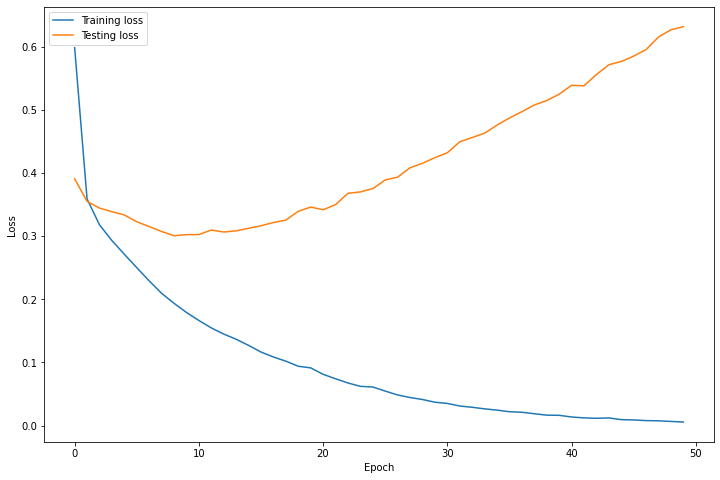

In [11]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [12]:
# Print accuracies of the last epoch
history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(1.0, 0.8752997517585754)

![](../assets/overkill.jpg)

## Regularization Method 1: $\mathcal{l}_1$ and $\mathcal{l}_2$
---
- Recall that each node in our neural network consists of both linear terms and non-linear activations. 
- The fact that we have linear terms allows us to use $l_1$ (LASSO) and $l_2$ (Ridge) regularization on our neural networks just as we did in our linear regression.

Recall from our notation:

* $J(\theta) = L(\mathbf{y}, \hat{\mathbf{y}})$ is the value of the loss function with respect to...
* $\theta$, the list of _all_ model coefficients (all weights and biases).

We regularize our neural networks by adding a penalty term to our loss function:

$$ \text{minimize } J(\theta) + \lambda \|\theta\|_2^2 $$

This has the effect of penalizing our parameters $\theta$ by shrinking them, hence bartering in the bias-variance tradeoff by (hopefully) reducing variance by adding bias. Although it is rarely done, **Keras actually gives us the opportunity to penalize the weights at different layers by different amounts.**

## Which to pick: $\mathcal{l}_1$ or $\mathcal{l}_2$?
Recall the key difference: $\mathcal{l}_1$ penalties perform _selection_. That is, they often zero out parameters when they're small enough. While this sounds appealing, $\mathcal{l}_2$ is used almost exclusively. It's done so often, that deep learning practitions give it a special name: **weight decay**. When in doubt, pls experiment!

In [13]:
# from tensorflow.keras import regularizers
# The regularization is added to each Dense layer!
from tensorflow.keras.regularizers import l2

# Model Architecture
model_l2 = Sequential()

n_input = X_train.shape[1]

model_l2.add(Dense(60, input_dim=n_input, activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(Dense(20, activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compile
opt = Adam(learning_rate=0.001)
model_l2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit
history_l2 = model_l2.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)

Epoch 1/50
79/79 [==============================] - 1s 3ms/step - loss: 1.2548 - accuracy: 0.8227 - val_loss: 1.0336 - val_accuracy: 0.8549
Epoch 2/50
79/79 [==============================] - 0s 1ms/step - loss: 0.8950 - accuracy: 0.8571 - val_loss: 0.7995 - val_accuracy: 0.8609
Epoch 3/50
79/79 [==============================] - 0s 2ms/step - loss: 0.7034 - accuracy: 0.8651 - val_loss: 0.6636 - val_accuracy: 0.8717
Epoch 4/50
79/79 [==============================] - 0s 1ms/step - loss: 0.5896 - accuracy: 0.8739 - val_loss: 0.5802 - val_accuracy: 0.8729
Epoch 5/50
79/79 [==============================] - 0s 1ms/step - loss: 0.5142 - accuracy: 0.8752 - val_loss: 0.5229 - val_accuracy: 0.8741
Epoch 6/50
79/79 [==============================] - 0s 1ms/step - loss: 0.4599 - accuracy: 0.8896 - val_loss: 0.4805 - val_accuracy: 0.8753
Epoch 7/50
79/79 [==============================] - 0s 1ms/step - loss: 0.4190 - accuracy: 0.8944 - val_loss: 0.4497 - val_accuracy: 0.8777
Epoch 8/50
79/79 [==

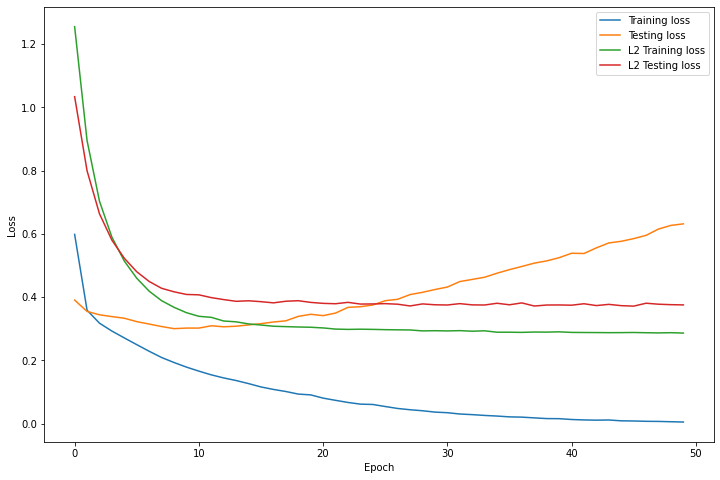

In [14]:
train_loss_l2 = history_l2.history['loss']
test_loss_l2 = history_l2.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.plot(train_loss_l2, label='L2 Training loss')
plt.plot(test_loss_l2, label='L2 Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [15]:
# Print accuracies of the last epoch
history_l2.history['accuracy'][-1], history_l2.history['val_accuracy'][-1]

(0.9487795233726501, 0.902877688407898)

## Keras Resources
- [Keras Regularization Documentation](https://keras.io/regularizers/)
- [Kernel vs. Activity Regularizers](https://github.com/keras-team/keras/issues/3236)

## Tensorflow Resources
- [Implementation in Tensorflow](https://www.tensorflow.org/versions/r0.12/api_docs/python/contrib.layers/regularizers)
- [Example in Tensorflow](http://www.ritchieng.com/machine-learning/deep-learning/tensorflow/regularization/)

<a id='dropout'></a>
## Regularization Method 2: Dropout
---
There's another method of regularizing our terms that is specifically designed for neural networks, called **dropout regularization.**

Let's say we've constructed a neural network. We've decided on the number of layers we want and the number of nodes in each layer. (We might say that we've decided on the **architecture** or **structure** of our network.)

![](../assets/original_nn.jpeg)

However, a densely connected network like this will almost certainly overfit. Our network is learning a parameter for every single connection.

> In the above example, we have 55 parameters being learned - and this is a very simple network, all things considered.

> We can overcome this by using **dropout regularization**. 

In dropout regularization, we randomly **drop** units (nodes) in our neural network ***during our training phase only***. We assign a probability of each node disappearing. Then, we essentially perform a coinflip for every node to turn that node "on" or "off."

Let's go through an example to illustrate this: For simplicity, we'll say we've assigned a 0.5 probability of keeping to every node in the network above. Then, for every node, we flip a coin, and if the coin lands on heads, the node remains, if it lands on tails, the node disappears. After we've done this for every node, we're left with a new network that looks something like this:

![](../assets/after_dropout.jpeg)

<!--
Image sources: https://pgaleone.eu/deep-learning/regularization/2017/01/10/anaysis-of-dropout/
Also, it seems, this site: http://cs231n.github.io/neural-networks-2/
-->

Let's explicitly lay out the general workflow you would follow:

1. Specify the architecture of your neural network.
1. Specify the "keeping probabilities" for every node. (Generally, we'll assign the same probability to all nodes in each layer and usually the same probability to all hidden layers.)
1. Perform a "coin flip" for each node and drop out the chosen nodes.
1. Run through one epoch of training.
1. Repeat steps 4 and 5 for each epoch of training.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif)

<details><summary>If I drop out a node during one of my epochs, does it disappear from my final network?</summary>

- No!
- Dropout is only invoked during training time and helps to prevent overfitting
- During model predictions, all dropout is automatically removed by keras
</details>

#### So, what does this do?
<!-- <br/> -->
The intuition behind dropout is that, since each node has a probability of disappearing at any time, the neural network is disincentivized from allocating too much power to any one weight. In that sense it has a similar effect as imposing an L2 penalty: the magnitude of our weights shrinks.

<details><summary>What might be some potential problems with doing this?</summary>

- expected values of nodes changes
- increases bias to reduce variance
</details>

So we've now run through every epoch of our training phase and we're ready to apply our neural network to our validation or testing data.

<details><summary>Are we going to apply dropout to this data as well?</summary>

- No!
- Dropout is only invoked during training time and helps to prevent overfitting
- During model predictions, all dropout is automatically removed by keras
</details>

#### Best practices:

- Don't set any keeping probabilities for layers you where you don't want to drop any nodes.

<details><summary>What might be examples of these layers?</summary>

- Input layers
- Output layers
</details>

- You'll generally want to specify a single keeping probability and all the layers on which you want to apply dropout, instead of specifying different keeping probabilities for each layer.

In [16]:
from tensorflow.keras.layers import Dropout

# Model Architecture
model_dropout = Sequential()

n_input = X_train.shape[1]

model_dropout.add(Dense(60, input_dim=n_input, activation='relu'))
model_dropout.add(Dropout(0.5)) # refers to nodes in the first hidden layer
model_dropout.add(Dense(20, activation='relu'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(1, activation='sigmoid'))

# Compile
opt = Adam(learning_rate=0.001)
model_dropout.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model_dropout.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 60)                4200      
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_7 (Dense)             (None, 20)                1220      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Model Fit
history_dropout = model_dropout.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test), 
    epochs=50,
    batch_size=32
)

Epoch 1/50
79/79 [==============================] - 1s 3ms/step - loss: 0.5668 - accuracy: 0.7547 - val_loss: 0.4302 - val_accuracy: 0.8549
Epoch 2/50
79/79 [==============================] - 0s 2ms/step - loss: 0.4954 - accuracy: 0.8283 - val_loss: 0.4159 - val_accuracy: 0.8549
Epoch 3/50
79/79 [==============================] - 0s 1ms/step - loss: 0.4614 - accuracy: 0.8411 - val_loss: 0.4047 - val_accuracy: 0.8549
Epoch 4/50
79/79 [==============================] - 0s 1ms/step - loss: 0.4311 - accuracy: 0.8491 - val_loss: 0.3882 - val_accuracy: 0.8549
Epoch 5/50
79/79 [==============================] - 0s 2ms/step - loss: 0.4121 - accuracy: 0.8547 - val_loss: 0.3850 - val_accuracy: 0.8549
Epoch 6/50
79/79 [==============================] - 0s 1ms/step - loss: 0.4036 - accuracy: 0.8555 - val_loss: 0.3767 - val_accuracy: 0.8549
Epoch 7/50
79/79 [==============================] - 0s 1ms/step - loss: 0.4036 - accuracy: 0.8543 - val_loss: 0.3720 - val_accuracy: 0.8549
Epoch 8/50
79/79 [==

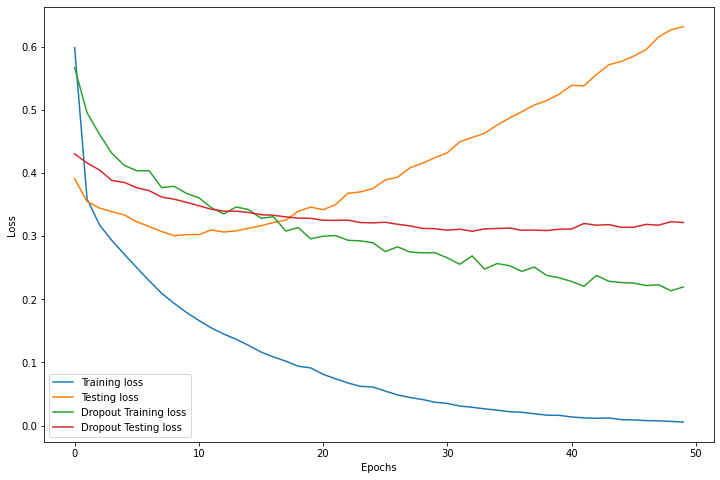

In [18]:
train_loss_dropout = history_dropout.history['loss']
test_loss_dropout = history_dropout.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.plot(train_loss_dropout, label='Dropout Training loss')
plt.plot(test_loss_dropout, label='Dropout Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [19]:
history_dropout.history['accuracy'][-1], history_dropout.history['val_accuracy'][-1]

(0.9135653972625732, 0.8968824744224548)

## Keras Resources
- [Keras Dropout Documentation](https://keras.io/layers/core/#dropout)

## Tensorflow Resources
- [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)
- [List of examples in Tensorflow](https://programtalk.com/python-examples/tensorflow.nn.dropout/)

<a id='stopping'></a>
## Regularization Method 3: Early Stopping
---
The third method of regularization that we'll discuss today is called early stopping.
</br>
If we run though all our epochs of training and plot both our training and validation error, we'll typically see something like this:

![](../assets/train-val-error-reduced.png)
*source*: [Prechelt, 1997](http://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf)

<details><summary>What is happening in this plot?</summary>

- The Validation error begins to increase after a certain number of epochs!
</details>

Early stopping does exactly what its name implies: it stop the training process early. Instead of continuing training through every epoch, once the validation error begins to increase, our algorithm stops because it has (in theory) found the minimum for the validation loss.

This might seem like a simple and robust solution to overfitting, but it can run into problems.

![](../assets/validation-error-real.png)

There is debate over how often this problem occurs. You can generally plot both the training and validation loss, see if you're getting multiple optima. If you are, there are multiple suggested techniques to combat this problem in the [paper reference above](http://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf).

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Model Architecture
model_es = Sequential()

n_input = X_train.shape[1]

model_es.add(Dense(60, input_dim=n_input, activation='relu'))
model_es.add(Dense(20, activation='relu'))
model_es.add(Dense(1, activation='sigmoid'))

# Compile
opt = Adam(learning_rate=0.001)
model_es.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Model Fit
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=5, 
                           mode='auto')

history_es = model_es.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop] # Add your callbacks here!
)

Epoch 1/50
79/79 [==============================] - 0s 2ms/step - loss: 0.4531 - accuracy: 0.8263 - val_loss: 0.3923 - val_accuracy: 0.8549
Epoch 2/50
79/79 [==============================] - 0s 1ms/step - loss: 0.3555 - accuracy: 0.8595 - val_loss: 0.3580 - val_accuracy: 0.8657
Epoch 3/50
79/79 [==============================] - 0s 1ms/step - loss: 0.3151 - accuracy: 0.8735 - val_loss: 0.3436 - val_accuracy: 0.8681
Epoch 4/50
79/79 [==============================] - 0s 1ms/step - loss: 0.2891 - accuracy: 0.8824 - val_loss: 0.3387 - val_accuracy: 0.8585
Epoch 5/50
79/79 [==============================] - 0s 1ms/step - loss: 0.2694 - accuracy: 0.8916 - val_loss: 0.3322 - val_accuracy: 0.8669
Epoch 6/50
79/79 [==============================] - 0s 2ms/step - loss: 0.2516 - accuracy: 0.8980 - val_loss: 0.3244 - val_accuracy: 0.8657
Epoch 7/50
79/79 [==============================] - 0s 1ms/step - loss: 0.2332 - accuracy: 0.9076 - val_loss: 0.3145 - val_accuracy: 0.8693
Epoch 8/50
79/79 [==

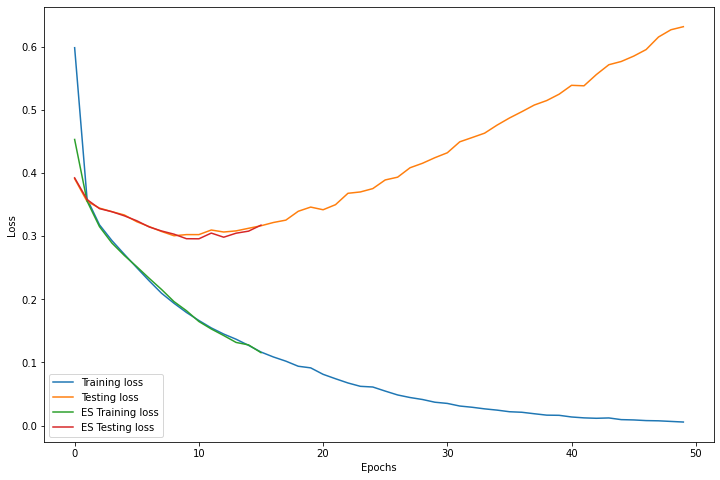

In [22]:
train_loss_es = history_es.history['loss']
test_loss_es = history_es.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.plot(train_loss_es, label='ES Training loss')
plt.plot(test_loss_es, label='ES Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [23]:
history_es.history['accuracy'][-1], history_es.history['val_accuracy'][-1]

(0.9619848132133484, 0.876498818397522)

## Keras Resources
- [Keras EarlyStopping Documentation](https://keras.io/callbacks/#earlystopping)
- [Keras EarlyStopping Example](http://parneetk.github.io/blog/neural-networks-in-keras/)

## Tensorflow Resources
- [Tensorflow.Keras.callbacks.EarlyStopping Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

# Optimization
---
Now we're going to talk about ways to speed up the process of optimization. Surprisingly, local optima are not often problems with neural networks; there's a much larger issue with "plateaus," or areas where the derivative is approximately 0. This makes learning much slower.

## Quick Fixes:
1. **Feature Scaling:** As we've discussed before, feature scaling can speed up the process of gradient descent. Because gradient descent works "geometrically," the scales of our $w$ values have a large impact on how quickly our parameters converge to the true value. Since we're working with many parameters (often 1,000 or more), scaling our features will speed up optimization.

2. **Mini-batch Gradient Descent:** In `sklearn`, we use `.fit()` to estimate the parameters in our model. We do the same in neural networks, but if we're working with a very large data set (as is common in neural networks), passing data through our network will cause learning to be slow. By specifying a `batch_size` within the `.fit()` method, we can expedite our learning.
    - `batch_size`: Integer or `None`. Number of samples per gradient update. If unspecified, it will default to 32.
    
**Note:** Mini batches will usually be a power of 2 (32, 64, 128, 256, 512) due to the fact that computers operate in base 2.

- [Overview of types of gradient descent](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)

## Advanced Optimisers:
- Pretty much everywhere these days you'd just use the Adam optimizer. More on Adam [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20is%20a%20replacement%20optimization,sparse%20gradients%20on%20noisy%20problems.).

### Data Augmentation
- This is a huge topic for Deep Learning.
- One method of minimizing the risk of overfitting is to gather more data. While this is usually very costly, we may sometimes be able to take our existing data to generate substantially more data.
- Images: Reflect, crop, random rotations or distortions, adjust lighting, etc
    - [The Effectiveness of Data Augmentation in Image Classification using Deep Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
- Text: Synonyms, antonyms, backtranslation (Engligh -> French -> English), etc
    - [NLPAug: NLP Augmentation library](https://github.com/makcedward/nlpaug)
- Tabular: [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) (Synthetic Minority Over-Sampling Technique)

<a id='conclusion'></a>
# Conclusion

Today, we learned about three different methods of regularizing our neural networks: Regularization, dropout, and early stopping.

## Machine Learning Workflow

As promised, managing bias and variance takes a lot of our attention. If our bias or variance are high, it's likely that our model isn't performing as well as it could.

A workflow for how you should address this (in the context of neural networks and beyond) is as follows:

- Do we have high bias? (i.e. are we performing poorly on our training set?)
    - If so:
        - let's build a more complex model / bigger network!
        - let's consider a new architecture for our neural network!
        - let's train longer!
- Do we have high variance? (i.e. are we performing poorly on our test/holdout set?)
    - If so:
        - let's gather more data!
            - Usually very difficult, but we should use "data augmentation" if we can!
        - let's build a simpler model / smaller network!
        - let's consider a new architecture for our neural network!
        - let's regularize!
    - Once we're satisfied, return to the bias question and repeat.
    
**Note:** Before deep learning, most tools for handling high bias or high variance adversely affected the other. However, depending on the amount of data we have and how complex our network is, it's often the case that we can drastically reduce variance with out affecting bias.

We also briefly discussed data augmentation as a method for increasing our sample size.

<a id='references'></a>
## References and Resources:

- [DeepLearning.ai](https://www.deeplearning.ai/), Andrew Ng's Coursera course on Deep Learning
  - The videos from this course are on a [YouTube Channel](https://www.youtube.com/channel/UCcIXc5mJsHVYTZR1maL5l9w/featured)   
<br>
- [Deep Learning Book](http://www.deeplearningbook.org/), textbook written by Ian Goodfellow, creator of Generative Adversarial Networks (GANs)